<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 11s


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

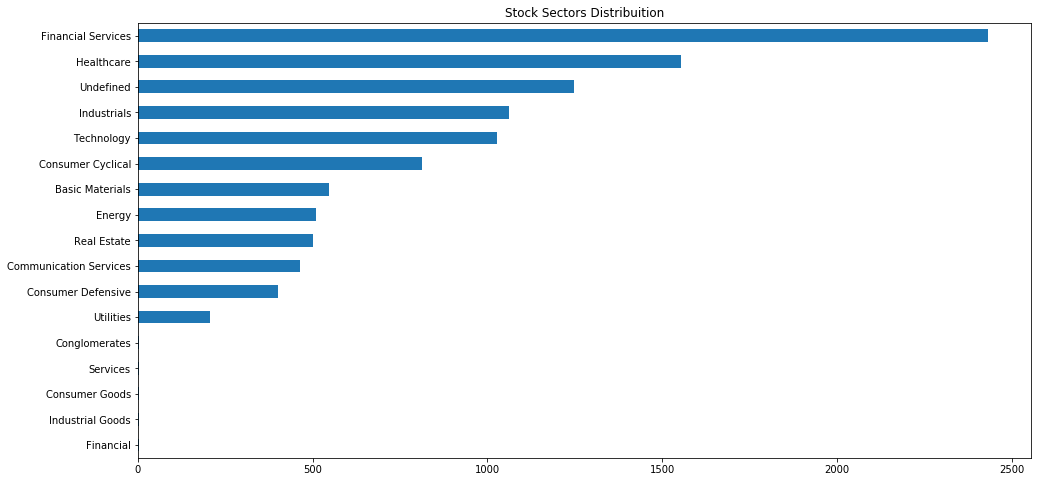

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [18]:
num_lags = 4

Чищу данные.

In [3]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
mask = (df['ssh_prn_amt_type'] == 'SH')
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = mask * df.ssh_prn_amt + (1 - mask) * df.market_value / df.close

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
df = df[df['shares'] > 0]
df = df[df['market_value'] > 0]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 25.6 s


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [15]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [4]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()
df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

Wall time: 7min 28s


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [17]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.392% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [5]:
%%time

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 5.28 s


In [6]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [7]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()

Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [8]:
funds_value.head()

,period,cik,market_value
0,2008Q4,1691827,331358000.0
1,2009Q4,1691827,394095000.0
2,2010Q4,1691827,106723104.0
3,2011Q4,1686409,1328000.0
4,2011Q4,1691827,67680000.0


In [9]:
high_value = np.quantile(funds_value.market_value, 2/3)
low_value = np.quantile(funds_value.market_value, 1/3)

high_value, low_value

(368264333.3333333, 87783666.66666666)

Рассмотрим некоторые основные описательные статистики.

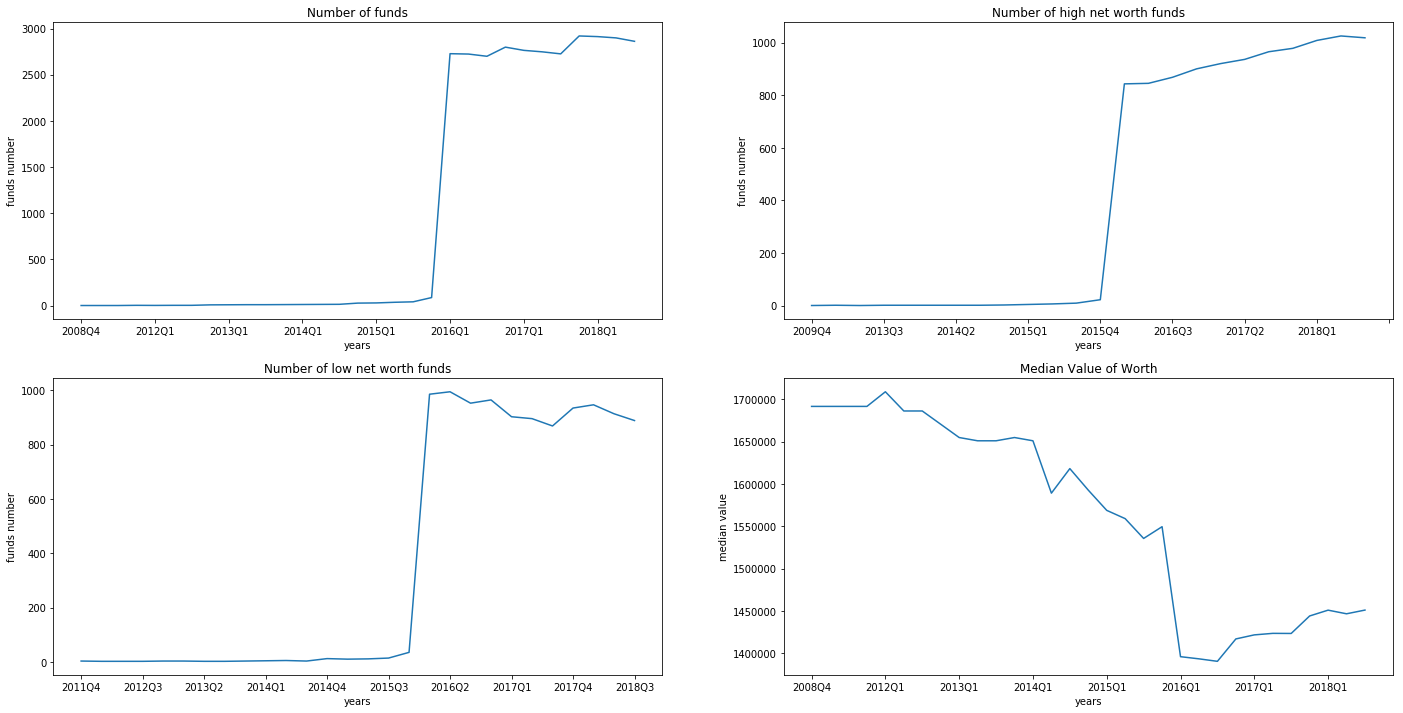

In [10]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [11]:
final_df = final_df[final_df.period >= '2016Q1']

Теперь я посмотрю на распределение ценности фондов.

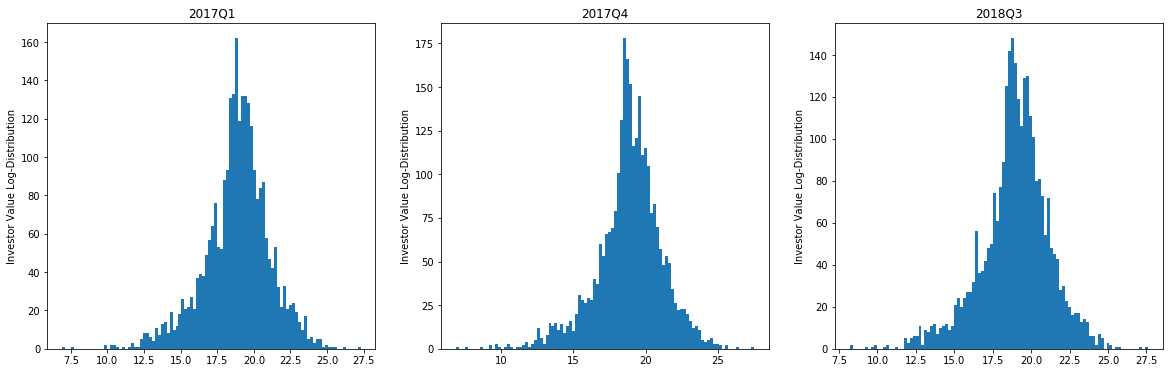

In [12]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [13]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.cut(final_df.market_value_fund, [0, low_value, high_value, final_df.market_value_fund.max()],
                              labels=['low', 'med', 'high'])

final_df['low_value'] = final_df.market_value_fund.le(low_value)
final_df['high_value'] = final_df.market_value_fund.ge(high_value)
final_df['med_value'] = ~(final_df['low_value'] + final_df['high_value'])

Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [19]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 2):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)

Wall time: 10.9 s


## Создание зависимой переменной

In [20]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 15.7 s


In [21]:
final_df[(final_df.shares_lag_1.eq(final_df.shares))].shape[0] / final_df.shape[0] * 100, '%'

(17.734870355430804, '%')

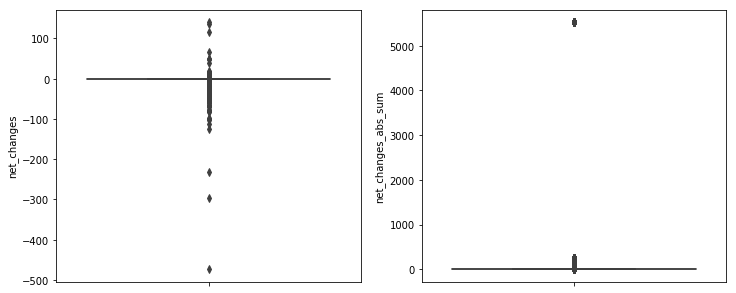

In [22]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

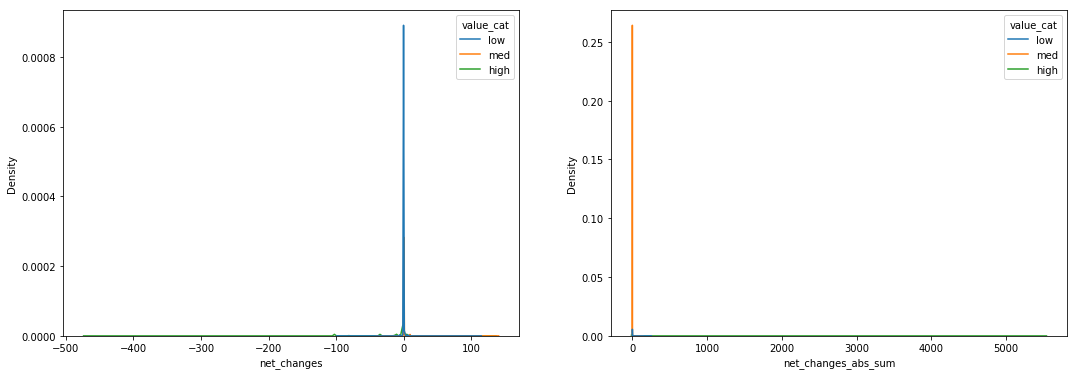

In [24]:
fig, ax = pl.subplots(1,2, figsize=(18,6));
sns.kdeplot(x='net_changes', hue="value_cat", data=final_df, ax=ax[0]);
sns.kdeplot(x='net_changes_abs_sum', hue="value_cat", data=final_df, ax=ax[1]);

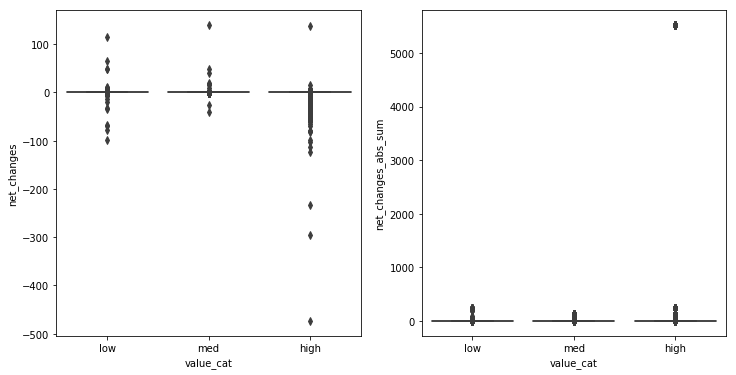

In [68]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

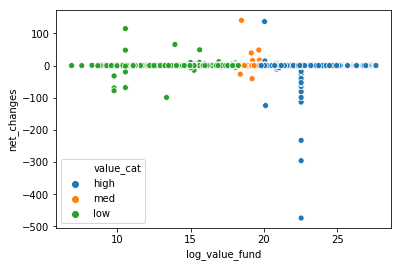

In [97]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

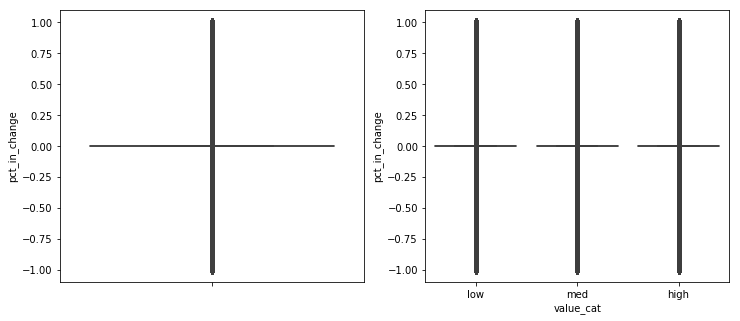

In [95]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

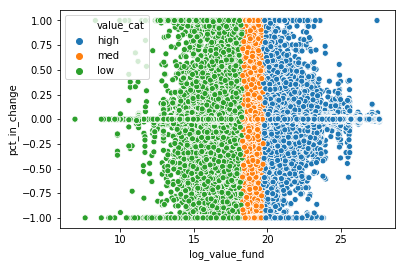

In [99]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [117]:
final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

final_df['ticker_share_lag_1'] = final_df.ticker_share.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1)).fillna(0)


In [118]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum()).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.head()

,period,cik,turnover
0,2016Q1,2230,1.0
1,2016Q1,3520,1.0
2,2016Q1,5272,1.0
3,2016Q1,7789,1.0
4,2016Q1,8565,1.0


Теперь HHI.

In [119]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum()).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,2230,0.017140
1,2016Q1,3520,0.017225
2,2016Q1,5272,0.010302
3,2016Q1,7789,0.045664
4,2016Q1,8565,0.648686


Теперь посмотрю на их распределение.

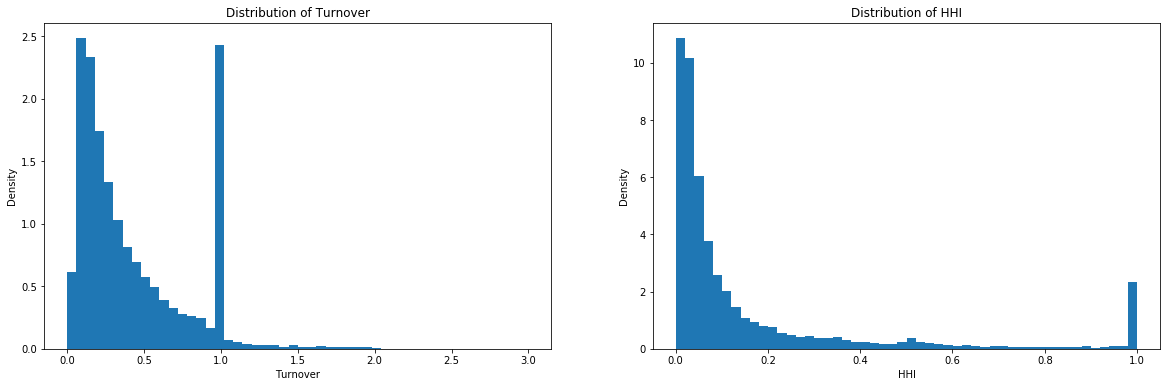

In [120]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].hist(turnover.turnover, density=True, bins=50, range=(0.001, 3));
axs[0].set_title('Distribution of Turnover');
axs[0].set(xlabel='Turnover', ylabel='Density');

axs[1].hist(hhi.hhi, density=True, bins=50, range=(0.001, 1));
axs[1].set_title('Distribution of HHI');
axs[1].set(xlabel='HHI', ylabel='Density');


Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

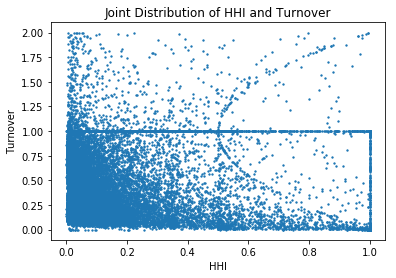

In [122]:
pl.scatter(hhi.hhi, turnover.turnover, s=1.8);
pl.xlabel('HHI');
pl.ylabel('Turnover');
pl.title('Joint Distribution of HHI and Turnover');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [184]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)
final_df['tvr_eq_1'] = final_df.turnover.eq(1)

In [200]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, 0), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, 0), labels=np.arange(10))

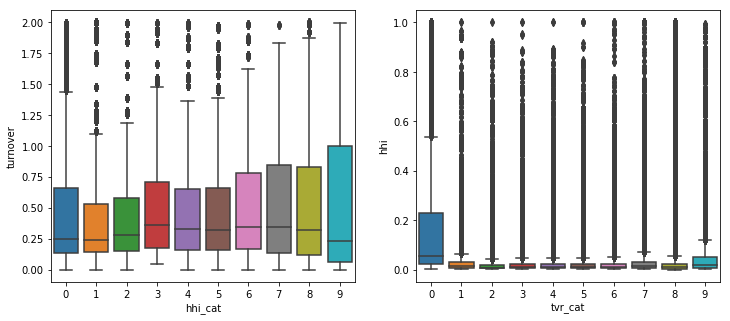

In [201]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

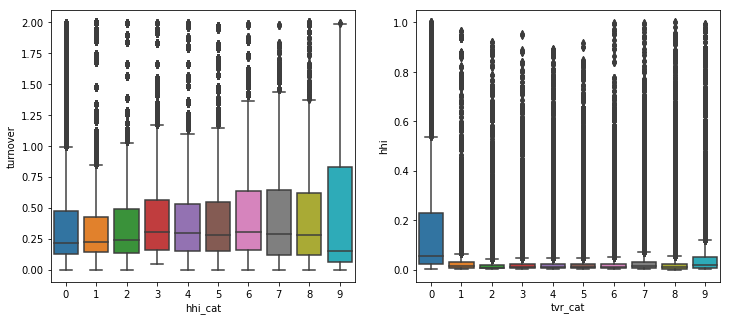

In [202]:
final_df_slice = final_df[(final_df.turnover.ne(1)) & (final_df.hhi.ne(1))]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

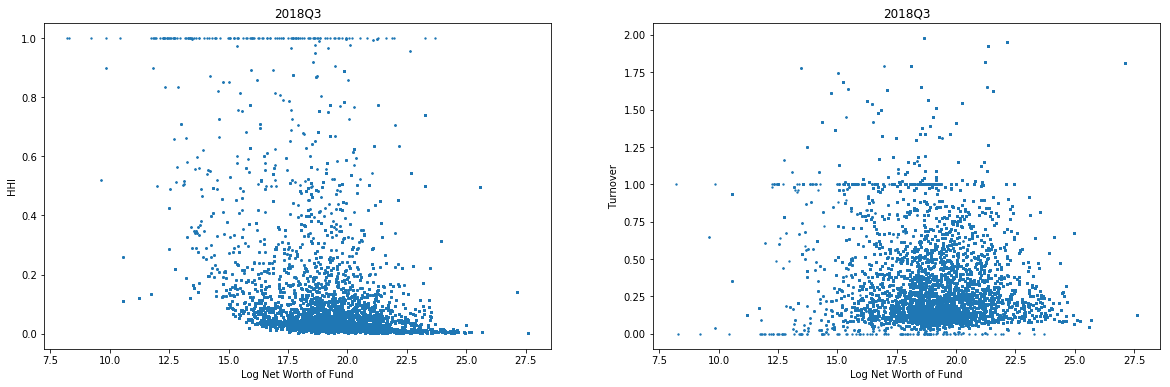

In [203]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

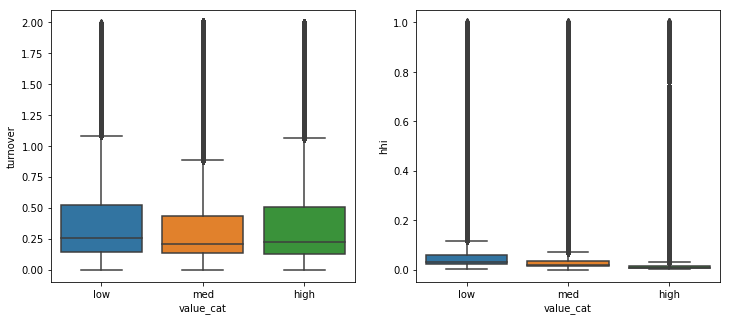

In [204]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='value_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df_slice, ax=ax[1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

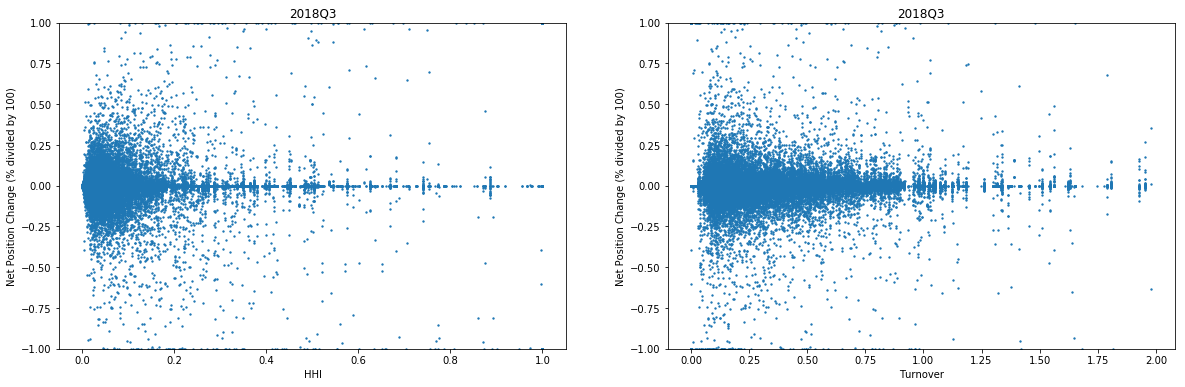

In [205]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].hhi,
           final_df[final_df.period == final_df.period.max()].pct_in_change, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='HHI', ylabel='Net Position Change (% divided by 100)');
axs[0].set_ylim(-1, 1);

axs[1].scatter(final_df[final_df.period == final_df.period.max()].turnover,
           final_df[final_df.period == final_df.period.max()].pct_in_change, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Turnover', ylabel='Net Position Change (% divided by 100)');
axs[1].set_ylim(-1, 1);

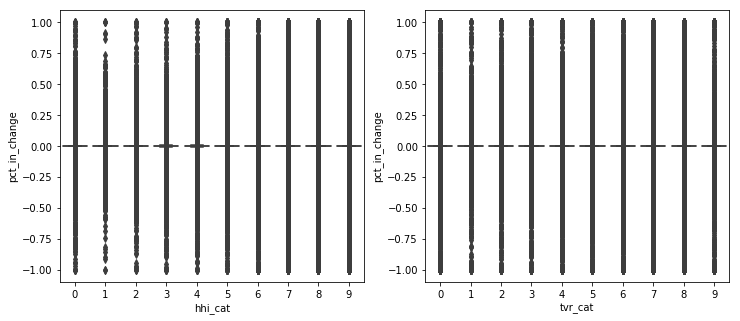

In [206]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df_slice, ax=ax[1]);

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [207]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2016Q1,2230,76
1,2016Q1,3520,363
2,2016Q1,5272,2990
3,2016Q1,7789,70
4,2016Q1,8565,2


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [208]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))
# Создаю лаг количества тикеров в фонде
final_df['pos_count_lag' + '_' + str(1)] = final_df.pos_count.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

Теперь посмотрим на распределение количества позиций в фонде.

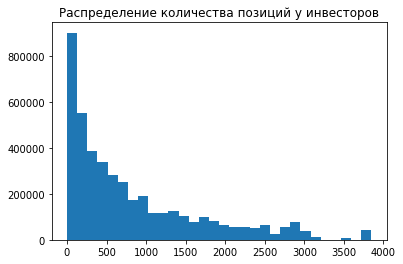

In [209]:
pl.hist(final_df.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [211]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [0, 30, 200, 500, 1000, 2000, 3000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '2000-3000', '>3000'])

Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

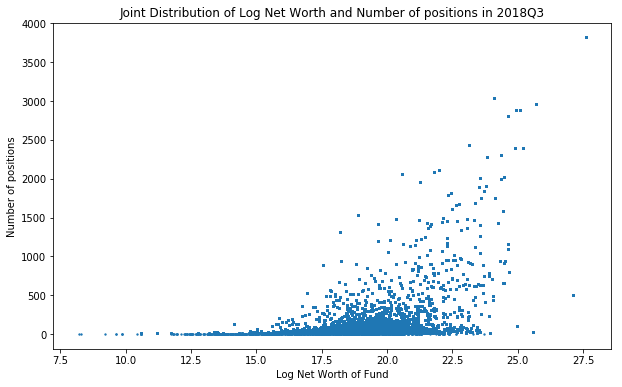

In [212]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
            final_df[final_df.period == final_df.period.max()].pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

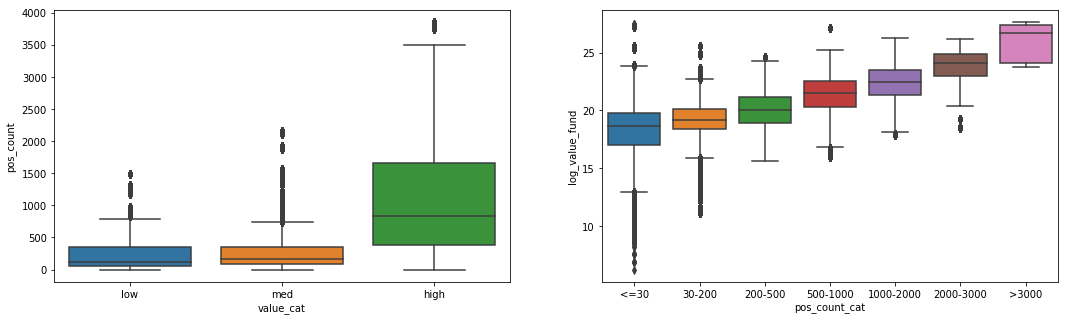

In [215]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

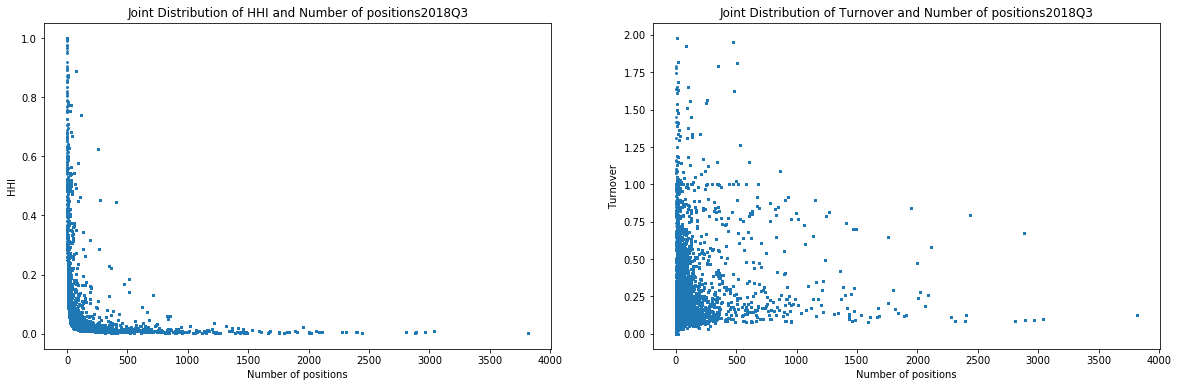

In [216]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].pos_count,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title('Joint Distribution of HHI and Number of positions' + str(final_df.period.max()));
axs[0].set(xlabel='Number of positions', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].pos_count,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title('Joint Distribution of Turnover and Number of positions' + str(final_df.period.max()));
axs[1].set(xlabel='Number of positions', ylabel='Turnover');

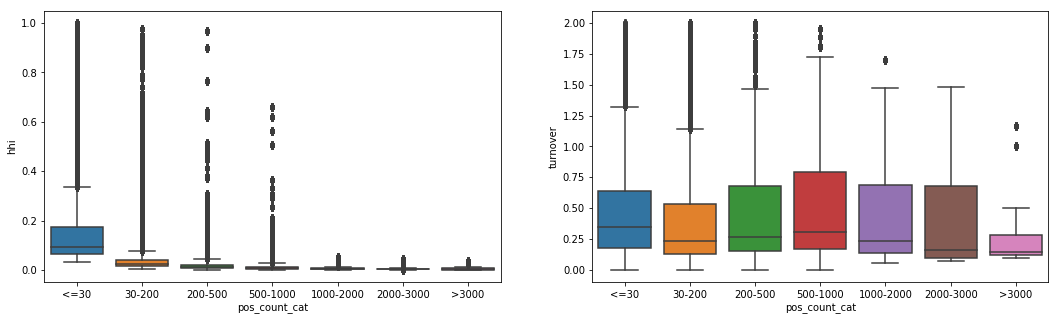

In [218]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[1]);

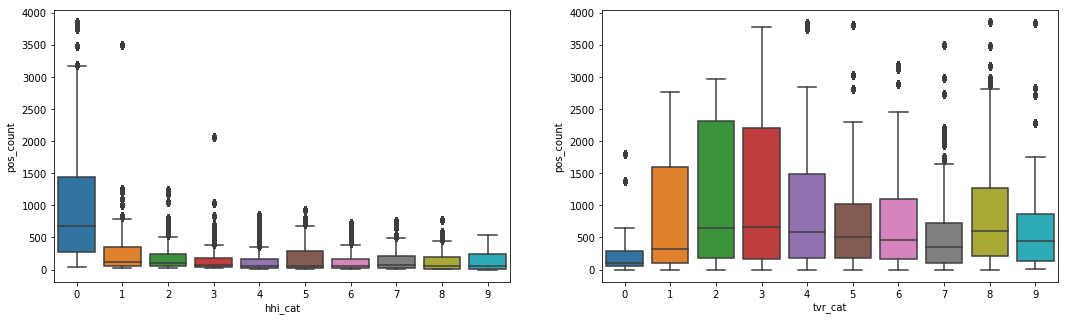

In [219]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[1]);

Связь с зависимой переменной.

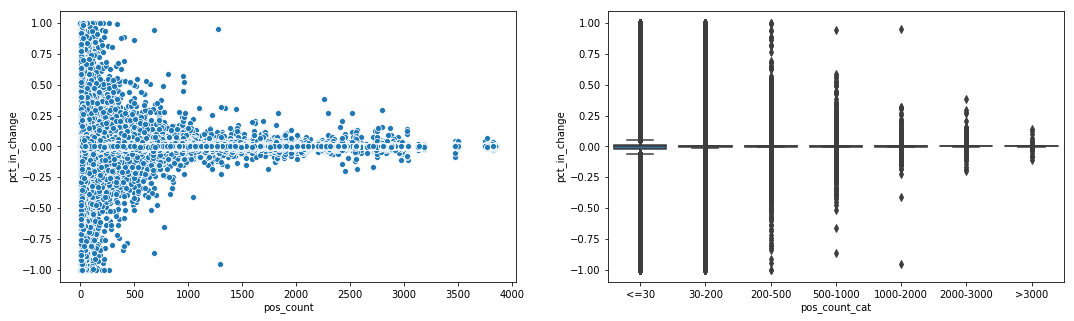

In [234]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [229]:
corr = final_df[['log_value_fund', 'value_cat', 'turnover', 'hhi', 'hhi_eq_1',
'tvr_eq_1', 'hhi_cat', 'high_turnover', 'tvr_cat', 'pos_count',
'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,turnover,hhi,hhi_eq_1,tvr_eq_1,pos_count
log_value_fund,1.00,-0.11,-0.60,-0.03,-0.03,0.72
turnover,-0.11,1.00,-0.01,-0.01,0.49,-0.03
hhi,-0.60,-0.01,1.00,0.03,-0.01,-0.76
hhi_eq_1,-0.03,-0.01,0.03,1.00,0.01,-0.03
tvr_eq_1,-0.03,0.49,-0.01,0.01,1.00,0.02
pos_count,0.72,-0.03,-0.76,-0.03,0.02,1.00


Добавление средних изменений зависимых переменных.

In [233]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values

Wall time: 57.9 s


## Макро

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [235]:
import pandas_datareader as wb

In [236]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [237]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [238]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [239]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 16.1 s


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [241]:
%%time

lag0 = final_df[final_df.pct_in_change_1.isna()].dropna()
lag1 = final_df[~final_df.pct_in_change_1.isna()].dropna()
lag2 = final_df[~final_df.pct_in_change_1.isna() * (~final_df.pct_in_change_2.isna())].dropna()
lag3 = final_df[(~final_df.pct_in_change_1.isna()) * (~final_df.pct_in_change_2.isna()) * \
                (~final_df.pct_in_change_3.isna())].dropna()
lag4 = final_df[(~final_df.pct_in_change_1.isna()) * (~final_df.pct_in_change_2.isna()) * \
                (~final_df.pct_in_change_3.isna()) * (~final_df.pct_in_change_4.isna())].dropna()

Wall time: 20.1 s


In [358]:
final_df_sam = final_df.sample(1000)

In [414]:
unpivoted = final_df_sam.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                .gt(0).unstack().reset_index(name='status')

unpivoted['quarter_sum'] = unpivoted.period.dt.year * 4 + unpivoted.period.dt.quarter - 1
unpivoted['object'] = unpivoted.ticker_id.apply(str) + '_' + unpivoted.cik.apply(str)

exit_mask = unpivoted.status.shift(1).where((unpivoted.object == unpivoted.object.shift(1)) &
                        (unpivoted.quarter_sum.diff(1).eq(1)) & (unpivoted.status.eq(False))).eq(True)



unpivoted['what'] = unpivoted.cik.apply(str) + '_' + unpivoted.ticker_id.apply(str) + '_' + unpivoted.period.apply(str)

unpivoted[exit_mask].what.isin(final_df._object).sum()

740

In [412]:
unpivoted[exit_mask][unpivoted[exit_mask].what.isin(final_df._object)].sort_values(['cik', 'ticker_id', 'period']).head()

,cik,ticker_id,period,status,quarter_sum,object,what
3739,3520,159612,2018Q3,False,8074,159612_3520,3520_159612_2018Q3
3324,3520,11159391,2016Q3,False,8066,11159391_3520,3520_11159391_2016Q3
7308,5272,829,2017Q1,False,8068,829_5272,5272_829_2017Q1
7143,5272,8252,2017Q1,False,8068,8252_5272,5272_8252_2017Q1
2631,5272,42496,2016Q3,False,8066,42496_5272,5272_42496_2016Q3


In [411]:
final_df[final_df._object.isin(unpivoted[exit_mask].what)].sort_values(['cik', 'ticker_id', 'period']).head()

,cik,period,ticker_id,access_id,conformed_submission_type,shares,market_value,stamp,close,_object,...,mean_pct_in_change,mean_pct_in_change_by_cik,mean_pct_in_change_by_value,tickers_count,tickers_count_by_value,DGS10,DFF,UNRATE,CPIAUCSL,GDP
3310880,3520,2018Q3,159612,0001104659-18-068290,13F-HR,27959.0,2164000.0,2018-11-14 09:12:11,77.40,3520_159612_2018Q3,...,-0.000975,0.002208,-0.000740,630,316.0,0.000032,0.001893,-1.666667e-03,0.005154,0.009248
4258922,3520,2016Q3,11159391,0001104659-16-156524,13F-HR,983401.0,23218000.0,2016-11-14 08:07:42,23.61,3520_11159391_2016Q3,...,-0.008496,-0.002169,0.000253,57,47.0,-0.001858,0.000256,-8.881784e-18,0.004670,0.008852
1509,5272,2017Q1,829,0000950123-17-004330,13F-HR,29496.0,473000.0,2017-05-10 16:46:13,16.05,5272_829_2017Q1,...,0.000489,0.000100,-0.006612,57,42.0,0.003079,0.002507,-2.000000e-03,0.007049,0.010763
364329,5272,2017Q1,8252,0000950123-17-004330,13F-HR,25183.0,237000.0,2017-05-10 16:46:13,9.40,5272_8252_2017Q1,...,-0.005590,0.000100,-0.000170,46,36.0,0.003079,0.002507,-2.000000e-03,0.007049,0.010763
1760912,5272,2016Q3,42496,0000950123-16-021531,13F-HR,6250708.0,442362605.0,2016-11-09 17:23:48,70.77,5272_42496_2016Q3,...,0.002868,0.000202,0.001495,237,159.0,-0.001858,0.000256,-8.881784e-18,0.004670,0.008852


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>. Начну с простой модели без факторизации.

### Модель 1

In [245]:
import statsmodels.api as sm

In [301]:
y = lag4['pct_in_change']

X = lag4[['log_value_fund', 'pos_count',
            'pct_in_change_1', 'pct_in_change_2',
            'pct_in_change_3', 'pct_in_change_4',
            'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
            'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
            'turnover', 'hhi', 'hhi_eq_1',
            'tvr_eq_1', 'mean_pct_in_change',
            'mean_pct_in_change_by_cik', 'mean_pct_in_change_by_value']].astype('float64')
X = sm.add_constant(X)

Делаю первую модель. Простой метод наименьших квадратов.

In [302]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5230.
Date:                Wed, 16 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:57:18   Log-Likelihood:             2.2936e+06
No. Observations:             1196086   AIC:                        -4.587e+06
Df Residuals:                 1196069   BIC:                        -4.587e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0019      0.000      4.024      0.000       0.001       0.003
log_value_fund                 -0.0002    2.6e-05     -5.791      0.000      -0.000   -9.98e-05
pos_count                    3.818e-07   5.68e-08      6.727      0.000    2.71e-07    4.93e-07
pct_in_change_1                 0.0820      0.001     91.074      0.000       0.080       0.084
pct_in_change_2                 0.0611      0.001     68.258      0.000       0.059       0.063
pct_in_change_3                 0.0463      0.001     51.984      0.000       0.045       0.048
pct_in_change_4                 0.0518      0.001     59.712      0.000       0.050       0.054
diff_value_fund_rank_lag_1      0.0024      0.000     19.601      0.000       0.002       0.003
diff_value_fund_rank_lag_2   1.072e-05      0.000      0.089      0.929      -0.000       0.000
diff_value_fund_rank_lag_3   4.495e-05      0.000      0.369      0.712      -0.000       0.000
diff_value_fund_rank_lag_4     -0.0003      0.000     -2.114      0.035      -0.001   -2.15e-05
turnover                       -0.0008      0.000     -5.000      0.000      -0.001      -0.000
hhi                            -0.0232      0.001    -36.284      0.000      -0.024      -0.022
hhi_eq_1                       -0.2768      0.006    -48.916      0.000      -0.288      -0.266
tvr_eq_1                     1.104e-16    4.2e-18     26.313      0.000    1.02e-16    1.19e-16
mean_pct_in_change              0.1736      0.006     28.803      0.000       0.162       0.185
mean_pct_in_change_by_cik       0.4153      0.003    155.222      0.000       0.410       0.421
mean_pct_in_change_by_value     0.4447      0.004    116.994      0.000       0.437       0.452
==============================================================================
Omnibus:                  1023037.045   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4761208023.039
Skew:                          -2.581   Prob(JB):                         0.00
Kurtosis:                     312.046   Cond. No.                     2.88e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.4e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [303]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

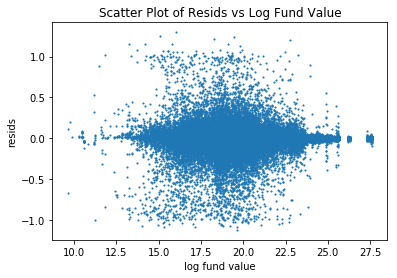

In [304]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

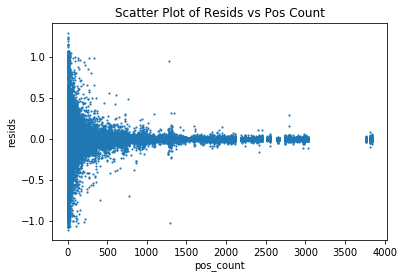

In [305]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

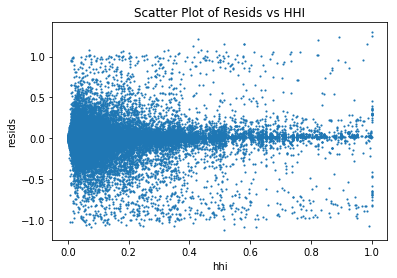

In [261]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

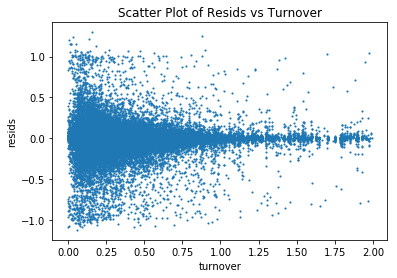

In [259]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

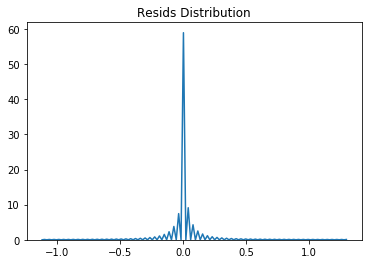

In [308]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [277]:
y = lag4['pct_in_change']

X = lag4[['log_value_fund', 'pos_count',
            'pct_in_change_1', 'pct_in_change_2',
            'pct_in_change_3', 'pct_in_change_4',
            'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
            'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
            'turnover', 'hhi', 'hhi_eq_1',
            'tvr_eq_1', 'mean_pct_in_change',
            'mean_pct_in_change_by_cik', 'mean_pct_in_change_by_value',
            'DGS10', 'DFF', 'UNRATE',
            'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [278]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3987.
Date:                Wed, 16 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:51:39   Log-Likelihood:             2.2936e+06
No. Observations:             1196086   AIC:                        -4.587e+06
Df Residuals:                 1196064   BIC:                        -4.587e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0053      0.001      5.924      0.000       0.004       0.007
log_value_fund                 -0.0002   2.61e-05     -6.132      0.000      -0.000      -0.000
pos_count                    3.779e-07   5.68e-08      6.657      0.000    2.67e-07    4.89e-07
pct_in_change_1                 0.0820      0.001     91.130      0.000       0.080       0.084
pct_in_change_2                 0.0611      0.001     68.290      0.000       0.059       0.063
pct_in_change_3                 0.0462      0.001     51.919      0.000       0.044       0.048
pct_in_change_4                 0.0518      0.001     59.715      0.000       0.050       0.054
diff_value_fund_rank_lag_1      0.0027      0.000     20.897      0.000       0.002       0.003
diff_value_fund_rank_lag_2     -0.0001      0.000     -1.003      0.316      -0.000       0.000
diff_value_fund_rank_lag_3  -9.042e-05      0.000     -0.689      0.491      -0.000       0.000
diff_value_fund_rank_lag_4     -0.0002      0.000     -1.468      0.142      -0.000    6.93e-05
turnover                       -0.0008      0.000     -5.174      0.000      -0.001      -0.001
hhi                            -0.0232      0.001    -36.331      0.000      -0.024      -0.022
hhi_eq_1                       -0.2768      0.006    -48.906      0.000      -0.288      -0.266
tvr_eq_1                     4.396e-16   1.21e-16      3.640      0.000    2.03e-16    6.76e-16
mean_pct_in_change              0.1724      0.006     28.578      0.000       0.161       0.184
mean_pct_in_change_by_cik       0.4146      0.003    154.821      0.000       0.409       0.420
mean_pct_in_change_by_value     0.4446      0.004    116.955      0.000       0.437       0.452
DGS10                           0.4493      0.079      5.673      0.000       0.294       0.604
DFF                            -0.3930      0.123     -3.189      0.001      -0.635      -0.151
UNRATE                          0.4112      0.123      3.331      0.001       0.169       0.653
CPIAUCSL                       -0.3306      0.080     -4.135      0.000      -0.487      -0.174
GDP                            -0.0376      0.021     -1.819      0.069      -0.078       0.003
==============================================================================
Omnibus:                  1023005.150   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4761766961.298
Skew:                          -2.581   Prob(JB):                         0.00
Kurtosis:                     312.064   Cond. No.                     1.53e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The sm

(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [71]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...